In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 400)
pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('isplay.max_colwidth', 300)
import re
import matplotlib.pyplot as plt
import IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
import nltk
nltk.download('stopwords')
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn import metrics
import seaborn as sns


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 # FINAL CAPSTONE PROJECT
 # Doing NLP with the Tim Ferriss Podcast
 ## Topic Modeling, Clustering and QnA

 ## Data set
 * Scraping https://tim.blog/2018/09/20/all-transcripts-from-the-tim-ferriss-show/ with the Python package BeautifulSoup
 * Output: csv file with all podcast episodes of number 151 - 375
 * all podcast of number before 151 do not have a HTML page

 ### Exploring the data

In [2]:
# Import raw data
# This data set contains the transcripts of Tim Ferriss Podcasts
# Source: https://tim.blog/2018/09/20/all-transcripts-from-the-tim-ferriss-show/
df = pd.read_csv("raw/transcript-151-3XX.csv")
df.columns=['id', 'title', 'text']
df.head()

# Cleaning the titles
df['title'] = df['title'].str.replace(r"The Tim Ferriss Show Transcripts: ", "")
df['title'] = df['title'].str.replace(r"Transcripts: ", "")
df['title'] = df['title'].str.replace(r"Tim Ferriss Show Transcript: ", "")
df['title'] = df['title'].str.replace(r"Episode ", "")

# Cleaning the transcript text
def clean_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"\\n\\n'", "")
    df[text_field] = df[text_field].str.replace(r"\\n", " ")
    df[text_field] = df[text_field].str.replace(r"\\xa0", " ")
    df[text_field] = df[text_field].str.replace(r"xa0", " ")
    return df
df = clean_text(df, "text")
df.head()



,id,title,text
0,151,Caroline Paul (#151),"'Maria said that Caroline is all about living courageously and embracing adventure in our culture of safe achievement. That is music to my ears. I feel like we’ve grown soft and weak, and it is time to remedy that with habits, practices, and stories that impart lessons.''On top of that, Caroline..."
1,152,On Philosophy and Riches (#152),"'And Seneca takes a little while with his preamble to get warmed up, but my favorite portion begins with: I might close my letter at this point. So you can use that as a bookmark. I might close my letter at this point. And I was talking to a friend of mine about Seneca. He’s a huge fan, also. An..."
2,153,BJ Miller (#153),"'Well, it turns out, BJ Miller, M.D., Dr. Miller, knows exactly this. BJ is a palliative care physician at Zen Hospice Project in San Francisco where he thinks deeply about how to create a dignified, graceful end of life for his patients. Now, this is, of course, not one of the usual suspects yo..."
3,154,Paulo Coelho (#154),"'His books of near universal appeal span from The Alchemist to the most recent, Adultery. And his work has been translated into more than 70 languages. Who knew there were even 70 languages on the planet? And few people know that The Alchemist, which was sold to an original Brazilian publisher, ..."
4,155,On Zero-to-Hero Transformations (#155),"'Instead, I am answering questions that you all or I should say many of you, wanted me to answer. There have been requests for me to do a Q&A, and I went onto the Facebook, www.Facebook.com/timferriss, and linked to a Reddit post where I had people submit and up-vote questions. At least 100 of..."


In [3]:
# Print out some stats
regexp_tokenizer = RegexpTokenizer(r'\w+')
word_tokens = df["text"].apply(regexp_tokenizer.tokenize)

# Inspecting our dataset a little more
all_words = [word for tokens in word_tokens for word in tokens]
sentence_lengths = [len(tokens) for tokens in word_tokens]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max episode length is %s" % max(sentence_lengths))
print("Mean episode length is %s" % np.mean(sentence_lengths))

label = df["title"].tolist()


3391754 words total, with a vocabulary size of 46322
Max episode length is 36769
Mean episode length is 15074.462222222222


 ### First findings
 This data set is large enough to do some sierous NLP. Dealing with a very long document size will ne challenge.

 ## Topic Modeling and Extraction
 To get a first impression this section will be doing some topic modeling and extraction.
 Applying a custome list of stop words is important here.
 A seperated python code will be load into this notebnook to remove these stopwords.

 #### Experiments
 * Used different number of topics (4, 5, 6)
 * Tried different parameter in each model

 #### NNFM
 * Set alpha from 0 to 0.1 --> much better results

In [4]:
from custom_stopwords import remove_custom_stopwords

# Parameters to set:
# Number of topics.
ntopics=4
# Number of words to look at for each topic.
n_top_words = 10

# Creating a dataframe to store the topic extraction results
topwords=pd.DataFrame()

# copy dataframe to convert the transcript to lower case
df_topic = df.copy()
df_topic['text'] = df_topic['text'].str.lower()

# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words=set(stopwords.words('english')), min_df=3, norm='l2')
podcasts_tfidf = vectorizer.fit_transform(remove_custom_stopwords(df_topic, 'text').text)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    topwords=pd.Series()
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        #print(chosen)
        # Combine loading and index into a string.
        for i, data in enumerate(chosen):
            chosenlist=chosen.index.values.tolist()[i] +" "+ str(round(data ,2))
            topwords = topwords.append(pd.Series([chosenlist], index=[column]))
    return(topwords)

# LSA
svd = TruncatedSVD(n_components=ntopics)
lsa_pipe = make_pipeline(svd, Normalizer(copy=False))
podcasts_lsa = lsa_pipe.fit_transform(podcasts_tfidf)

components_lsa = word_topic(podcasts_tfidf, podcasts_lsa, terms)

topwords['LSA'] = top_words(components_lsa, n_top_words) 

# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics, 
          doc_topic_prior=1/ntopics,
          topic_word_prior=1/ntopics,
          learning_decay=0.6, # Convergence rate.
          learning_offset=5.0, # Causes earlier iterations to have less influence on the learning
          max_iter=500, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=3, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=32
         )

podcasts_lda = lda.fit_transform(podcasts_tfidf) 

components_lda = word_topic(podcasts_tfidf, podcasts_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.1, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.5, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=400, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=65, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
podcasts_nmf = nmf.fit_transform(podcasts_tfidf) 

components_nmf = word_topic(podcasts_tfidf, podcasts_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

#Show topics
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])


Topic 0:
            LSA          LDA         NNMF
0  people 31.98  people 0.35  people 8.19
0   think 29.43   think 0.32   think 7.66
0     one 26.74     one 0.29     one 6.76
0    time 19.67    time 0.21    time 5.01
0    know 17.53    know 0.19    know 4.49
0  things 17.41  things 0.19  things 4.49
0     say 16.63     say 0.18     say 4.26
0      go 15.25    want 0.17      go 3.89
0    want 15.23      go 0.17    want 3.87
0     lot 14.52     lot 0.16     lot 3.74
Topic 1:
              LSA          LDA            NNMF
1       diet 1.11  people 0.35  ketogenic 0.96
1  ketogenic 1.06   think 0.32       diet 0.81
1    training 0.8     one 0.29    ketones 0.41
1       body 0.64    time 0.21    ketosis 0.36
1    glucose 0.56    know 0.19    glucose 0.35
1      coach 0.53  things 0.19     ketone 0.33
1    ketones 0.53     say 0.18      think 0.28
1     muscle 0.52    want 0.17     oxygen 0.27
1   strength 0.51      go 0.17       beta 0.23
1    ketosis 0.47     lot 0.16        one 0.21
Top

 ### Findings
 * 4 topics have the best consistency troughout the two models LSA and NNFM. They show similar top words.
 * 4 topics also make sense if you consider the words semantics
 * LDA performance poorly. It contains the same top words in each topic
 * NNFM performance the best. Here the top words are better related to each other than in LSA.

 #### Found topics:
 1. Ketogenic diet
 2. Training
 3. Psychedelics
 4. All other

 ## Tokenize with pre-trained language model
 It is time to use current advances in NLP by using common transformer architectures pre-trained on a large corpus of text like from the Wikipedia.
 ### Experiments
 * Used Distill Bert, Bert, XLNet
 * uncased and cased
 * Clustering (number of cluster is 4, like the best number of topics, which was a finding of the topic modeling part)
 * metric: silhouette_score

In [5]:
#Load distil BERT Model
nlp = spacy.load('/usr/local/lib/python3.7/site-packages/en_pytt_xlnetbasecased_lg/en_pytt_xlnetbasecased_lg-2.1.1')
n_items = 86 # Enough data for this show case



In [6]:
# Vectorize transcripts with spacy  
def get_embeddings_with_spacy(tokenizer, df):
    embeddings = df['text'].apply(lambda x: tokenizer(x).vector)
    return list(embeddings)

spacy_transformer_embeddings = get_embeddings_with_spacy(nlp, df[:n_items])



In [7]:
# Create dataframe
df_emb_spacy = pd.DataFrame(spacy_transformer_embeddings)

# Normalize 
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(df_emb_spacy) 
df_emb_spacy.loc[:,:] = scaled_values


silhouette score:  0.2785538073001246


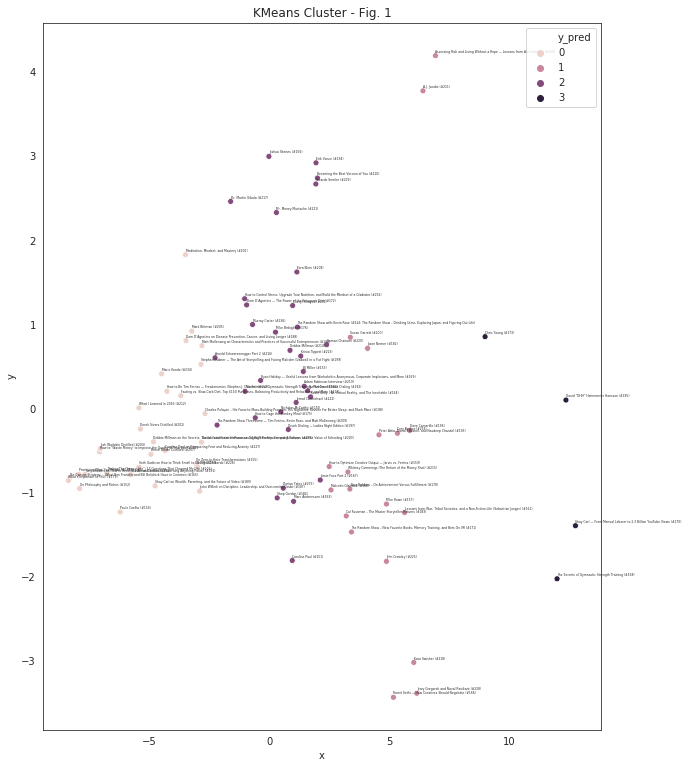

In [8]:
# Clustering 

# Calculate predicted values.
km = KMeans(n_clusters=4, random_state=42).fit(df_emb_spacy)
y_pred = km.predict(df_emb_spacy)

print('silhouette score: ', metrics.silhouette_score(df_emb_spacy, y_pred, metric='euclidean'))

# 2D
lsa = PCA(n_components=2)
las_results = lsa.fit_transform(df_emb_spacy.values)
las_results = pd.DataFrame(las_results, columns=['x', 'y'])

df_y = pd.DataFrame(y_pred, columns=['y_pred'])
df_y['y_pred'] = df_y['y_pred'].astype(int)

las_results = pd.concat([las_results, df_y], axis=1)

#Plot
sns.set_style("white")
plt.figure(figsize=(10, 13))  
fig = sns.scatterplot(x=las_results['x'], y=las_results['y'], hue=las_results['y_pred'])
for i, txt in enumerate(label[:n_items]):
    fig.annotate(txt, # this is the text
                 (las_results['x'].values[i],las_results['y'].values[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,3), # distance from text to points (x,y)
                 ha='left', # horizontal alignment can be left, right or center
                 size=3)
fig.set_title("KMeans Cluster - Fig. 1", fontsize=12)
plt.show()


 ### Findings:
 WIth more and more clusters the silhouette score is going down. So it is not going to help if you increase the cluster number or regarding the topic modeling part to increase the number of topics.
 With this data set it also is very hard to find clusters in general. It looks like all the topics of the Tim Ferris show are very diverse and seamlessly complete each other. There is no obvious way to divide them. Looks like the clusters have a similar variance. That is why k-Means is not working well here.

 ## Question and Answering (QnA
 ### Building a Tim Ferriss Bot
 The goal is to build a question and answering system with the podcast transcript corpus.
 This project is going to use cdQA, an End-To-End Closed Domain Question Answering System Framework: https://cdqa-suite.github.io/cdQA-website/

 Because we are only using these transcripts and we are only think about questions which should be get an answer out of this data set this QnA system will be closed domain one.

In [0]:
# Create paragraphs
# Use the interview structure and split it when Tim Ferriss starts to aks a question
# If the podcast transcript has no structured interview then remove it from the data set
# The treshold is 7. That means we could not split the transcript into 7 different pieces. 
df['paragraphs'] = df['text'].apply(lambda x: x.split("''Tim Ferriss:") if len(x.split("''Tim Ferriss:")) > 7 else None)

# Define X
df_X = df.drop(columns=['text', 'id']).dropna()
df_X.reset_index(drop=True, inplace=True)

# Generate squad v1.1 json file so you can create annotated question and answers to fine-tune the model and evaluate it
from cdqa.utils.converters import df2squad
json_data = df2squad(df=df_X, squad_version='v1.1', output_dir='.', filename='qna_tim_ferriss')
# From there we can use https://github.com/cdqa-suite/cdQA-annotator to create a supervised problem


 ### Fine-Tuning

In [0]:
# Fine-tune Bert model with squad v1.1 custom data set of Tim Ferriss questions
import os
import torch
from sklearn.externals import joblib
from cdqa.reader.bertqa_sklearn import BertProcessor, BertQA

train_processor = BertProcessor(do_lower_case=True, is_training=True)
train_examples, train_features = train_processor.fit_transform(X='cdqa-v1.1-tim_qna.json')

reader = BertQA(train_batch_size=12,
                learning_rate=3e-5,
                num_train_epochs=2,
                do_lower_case=True,
                output_dir='models')

reader.fit(X=(train_examples, train_features))

# Output fine-tuned model
reader.model.to('cpu')
reader.device = torch.device('cpu')
joblib.dump(reader, os.path.join(reader.output_dir, 'bert_tim_qa_vCPU.joblib'))


 ### Training

In [0]:
from cdqa.pipeline.cdqa_sklearn import QAPipeline

# Load standard model
cdqa_pipeline = QAPipeline(model='./cdqa/bert_qa_vCPU-sklearn.joblib', max_answer_length=60)
cdqa_pipeline.fit_retriever(X=df_X)



In [0]:
# Evaluate QnA system
from cdqa.utils.evaluation import evaluate_pipeline
evaluate_pipeline(cdqa_pipeline, 'cdqa-v1.1-tim_qna.json')

# Standard pre trained model: {'exact_match': 0.0, 'f1': 5.025362668068075}
# Fine-tuned model: {'exact_match': 0.0, 'f1': 5.684362620078064}


 ### Inference

In [0]:
prediction = cdqa_pipeline.predict(X='what would be a good gymnastic strength training goal to have?')
print('title: {}'.format(prediction[1]))
print('paragraph: {}'.format(prediction[2]))
print('answer: {}'.format(prediction[0]))


 ### Findings:
 * Fine-tuning results in worse performance
 * F1 score is really low --> not a good QnA system
 * Inferene is very slow on mediocre hardware
 * Inference results are also bad

 ### Identified issues
 * too many paragraphs --> initial choice on the document to find the answer is too hard with tf-idf
 * too many paragraphs with too short text, bad for tf-idf and to predict the answer
 * too slow hardware
 * fine tuning the QnA model is not working --> to less labled examples
 * even the paraprashes dervied from an interview text are not fitting to this problem right away, Tim Ferriss is not asking a lot of question
 * in this podcast they are more telling stories than asking and answering questions --> this makes it harder to find QnA pairs and to learn from the corpus.

 ## Conclusion

 This text corpus is way more challenging than expected. Topic modeling and extraction works quite well, but using pre-trained models and state of the art transformer architectues have not lived up the praise. Result are far away to think about operationalizing the model.

 #### Things to do next:
 * Fine tune transformer model and clustering, also for QnA model
 * Use a transformer model for topic modeling and extraction
 * Get more QnA pairs
 * Get rid of unhelpful paragraphs for the QnA model
 * Use FARM as an alternative framework to build a QnA model
 * Build an API
 * Build a Telegram Chatbot

 ### Miscellaneous

In [0]:
# Fix issue where the id is missing
import uuid
import json

with open('cdqa-v1.1-xxxx.json') as json_file:
    annotated_dataset = json.load(json_file)

for doc in annotated_dataset['data']:
    for p in doc['paragraphs']:
        for qa in p['qas']:
            qa['id'] = str(uuid.uuid4())

with open('cdqa-v1.1-tim_qna.json', 'w') as outfile:
    json.dump(annotated_dataset, outfile)


